# Modeling

## Setup

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
seed = 42

## Load and inspect data

In [3]:
train_test = gpd.read_file('../../data/train_test.shp')
train_test.shape

(19656, 33)

In [4]:
train_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19656 entries, 0 to 19655
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state       19656 non-null  object  
 1   district    19656 non-null  object  
 2   year        19656 non-null  int64   
 3   month       19656 non-null  int64   
 4   outbreak    19656 non-null  int64   
 5   sss         5724 non-null   float64 
 6   sss_1m_l    5724 non-null   float64 
 7   sss_c_1m_l  5724 non-null   float64 
 8   sss_d_1m_l  5724 non-null   float64 
 9   sss_2m_l    5724 non-null   float64 
 10  sss_c_2m_l  5724 non-null   float64 
 11  sss_d_2m_l  5724 non-null   float64 
 12  chl         7066 non-null   float64 
 13  chl_1m_l    7066 non-null   float64 
 14  chl_c_1m_l  7066 non-null   float64 
 15  chl_d_1m_l  7066 non-null   float64 
 16  chl_2m_l    7066 non-null   float64 
 17  chl_c_2m_l  7066 non-null   float64 
 18  chl_d_2m_l  7066 non-null   float64 
 

In [5]:
train_test.head()

,state,district,year,month,outbreak,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,...,lst_2m_l,lst_c_2m_l,lst_d_2m_l,east,west,mnsn,post_mnsn,pre_mnsn,winter,geometry
0,gujarat,ahmadabad,2010,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1,0,0,0,1,"POLYGON ((3179537.224 3816985.054, 3178528.703..."
1,gujarat,ahmadabad,2010,2,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1,0,0,0,1,"POLYGON ((3179537.224 3816985.054, 3178528.703..."
2,gujarat,ahmadabad,2010,3,0,NaN,NaN,NaN,NaN,NaN,...,306.614266,4.415403,1.0,0,1,0,0,1,0,"POLYGON ((3179537.224 3816985.054, 3178528.703..."
3,gujarat,ahmadabad,2010,4,0,NaN,NaN,NaN,NaN,NaN,...,310.196242,4.957989,1.0,0,1,0,0,1,0,"POLYGON ((3179537.224 3816985.054, 3178528.703..."
4,gujarat,ahmadabad,2010,5,0,NaN,NaN,NaN,NaN,NaN,...,320.152522,2.264764,1.0,0,1,0,0,1,0,"POLYGON ((3179537.224 3816985.054, 3178528.703..."


<AxesSubplot: >

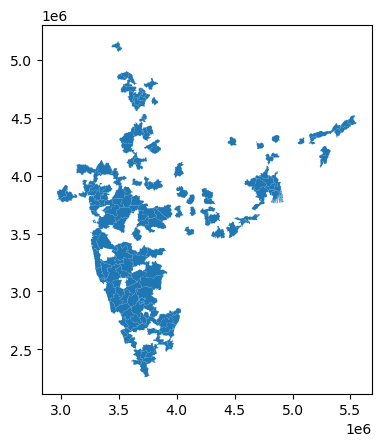

In [6]:
train_test['geometry'].drop_duplicates().plot()

In [7]:
train_test.isna().sum()

state             0
district          0
year              0
month             0
outbreak          0
sss           13932
sss_1m_l      13932
sss_c_1m_l    13932
sss_d_1m_l    13932
sss_2m_l      13932
sss_c_2m_l    13932
sss_d_2m_l    13932
chl           12590
chl_1m_l      12590
chl_c_1m_l    12590
chl_d_1m_l    12590
chl_2m_l      12590
chl_c_2m_l    12590
chl_d_2m_l    12590
lst             892
lst_1m_l        892
lst_c_1m_l      892
lst_d_1m_l      892
lst_2m_l        892
lst_c_2m_l      892
lst_d_2m_l      892
east              0
west              0
mnsn              0
post_mnsn         0
pre_mnsn          0
winter            0
geometry          0
dtype: int64

Drop districts entirely if they don't have a complete timeseries, i. e. missing values for some ECV features?

In [8]:
train_test = train_test.dropna().reset_index(drop=True)
train_test.shape

(5522, 33)

## Check feature distributions

In [9]:
def plot_feature_distributions(data, columns):

    fig, axes = plt.subplots(1, len(columns), sharey=True, figsize=(9, 3))
    axes = axes.ravel()

    for col, ax in zip(columns, axes):
        sns.histplot(data, x=col, hue='outbreak', multiple='dodge', stat='probability', common_norm=False, ax=ax)

    fig.tight_layout()
    plt.show()

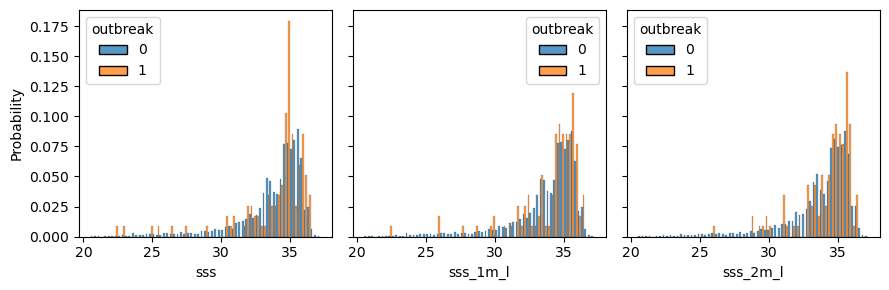

In [10]:
plot_feature_distributions(train_test, ['sss', 'sss_1m_l', 'sss_2m_l'])

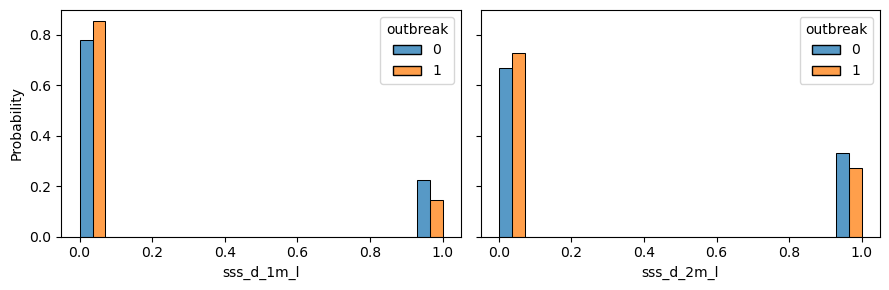

In [11]:
plot_feature_distributions(train_test, ['sss_d_1m_l', 'sss_d_2m_l'])

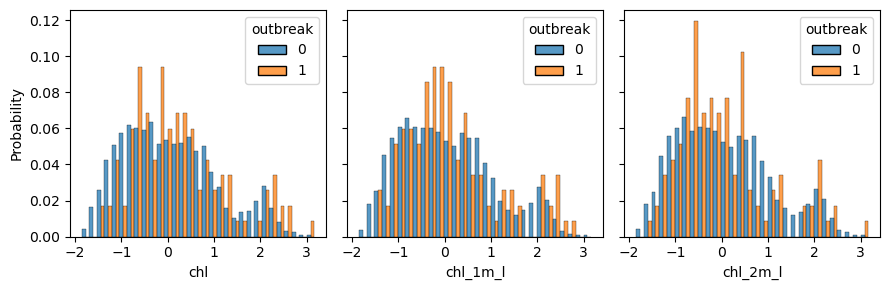

In [12]:
plot_feature_distributions(train_test, ['chl', 'chl_1m_l', 'chl_2m_l'])

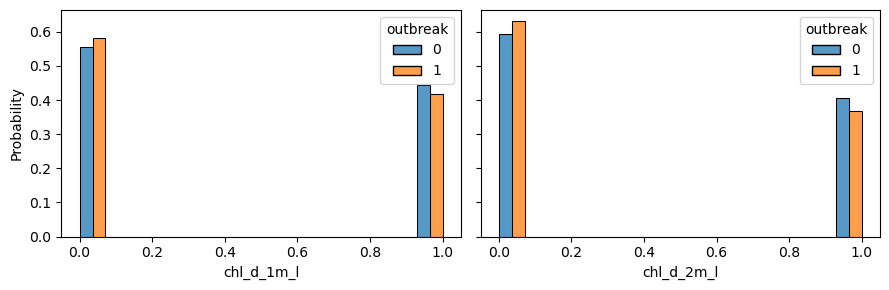

In [13]:
plot_feature_distributions(train_test, ['chl_d_1m_l', 'chl_d_2m_l'])

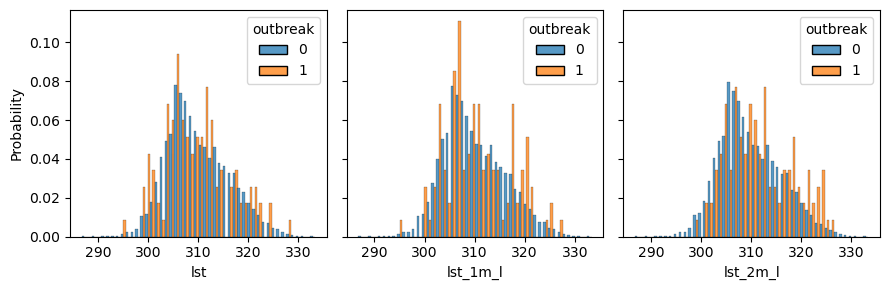

In [14]:
plot_feature_distributions(train_test, ['lst', 'lst_1m_l', 'lst_2m_l'])

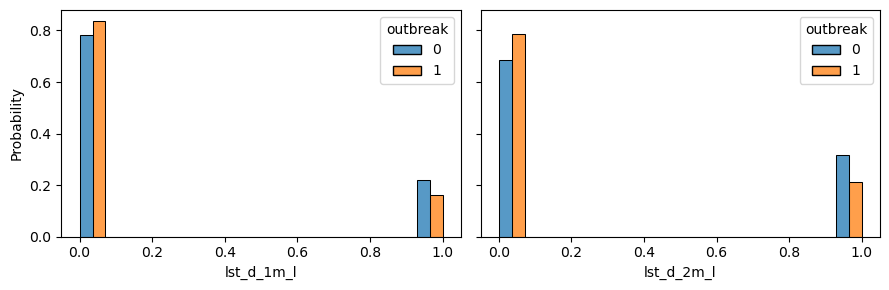

In [15]:
plot_feature_distributions(train_test, ['lst_d_1m_l', 'lst_d_2m_l'])

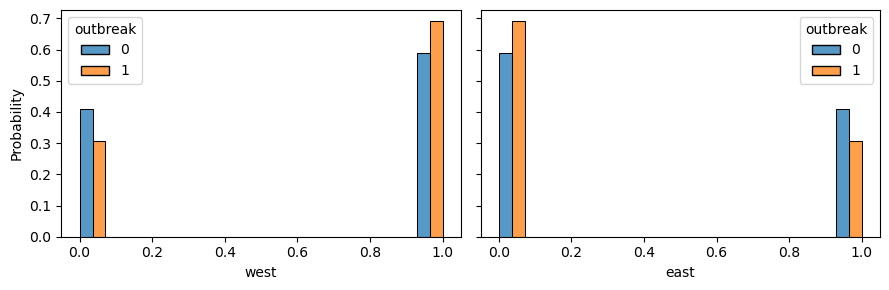

In [16]:
plot_feature_distributions(train_test, ['west', 'east'])

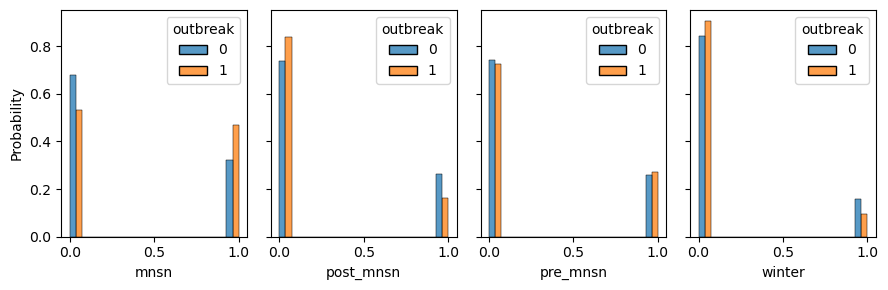

In [17]:
plot_feature_distributions(train_test, ['mnsn', 'post_mnsn', 'pre_mnsn', 'winter'])

## Train test split

In [18]:
districts = train_test[['district']]

In [19]:
districts.nunique()

district    54
dtype: int64

In [20]:
districts.value_counts()

district              
mysore                    106
virudunagar               106
madurai                   106
viluppuram                106
tirunelveli               106
tiruvannamalai            106
shimoga                   105
belgaum                   105
kolhapur                  105
ratnagiri                 105
uttara kannada            105
vellore                   105
ganjam                    105
dharwad                   105
tiruchirappalli           105
cuddalore                 105
chikmagalur               105
haveri                    105
sangli                    104
rayagada                  104
raigarh                   104
pune                      104
pathanamthitta            104
thanjavur                 104
kancheepuram              104
cuttack                   104
hassan                    104
rajkot                    103
nashik                    103
thiruvarur                103
idukki                    103
sindhudurg                102
jamnagar         

In [21]:
X = train_test.drop(['state', 'district', 'year', 'month', 'outbreak', 'geometry'], axis=1)

In [22]:
y = train_test['outbreak']

In [23]:
y.value_counts()

0    5405
1     117
Name: outbreak, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

## Train random forest

In [25]:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)

In [26]:
%%time

rf.fit(X_train, y_train)

CPU times: user 717 ms, sys: 18 µs, total: 717 ms
Wall time: 720 ms


RandomForestClassifier(n_estimators=50, random_state=42)

In [27]:
y_pred = rf.predict(X_test)

## Evaluation

In [28]:
print(confusion_matrix(y_test, y_pred))

[[1627    1]
 [  29    0]]


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1628
           1       0.00      0.00      0.00        29

    accuracy                           0.98      1657
   macro avg       0.49      0.50      0.50      1657
weighted avg       0.97      0.98      0.97      1657



In [30]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [31]:
auc = roc_auc_score(y_test, y_pred_proba)

In [32]:
auc

0.5706070490553249

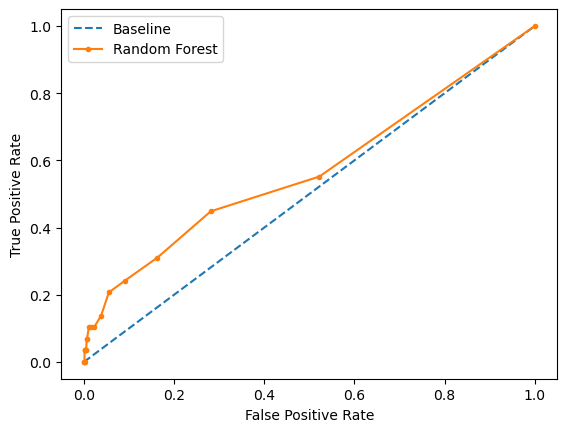

In [33]:
baseline = [0 for _ in range(len(y_test))]
baseline_auc = roc_auc_score(y_test, baseline)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

In [34]:
feature_names = X.columns
importances = rf.feature_importances_
rf_importances = pd.Series(importances, index=feature_names).sort_values()

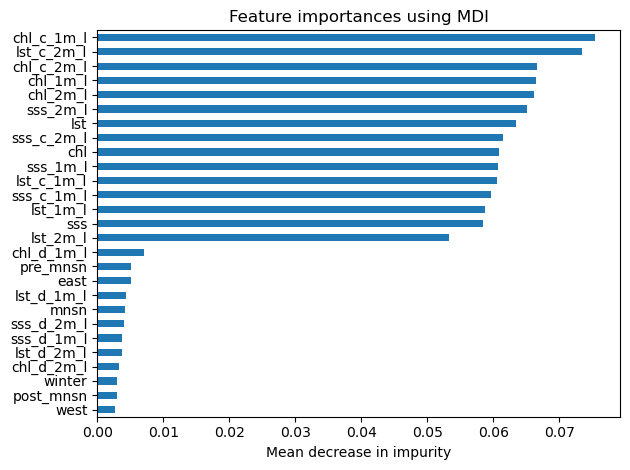

In [35]:
fig, ax = plt.subplots()
rf_importances.plot.barh(ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_xlabel('Mean decrease in impurity')
fig.tight_layout()

## SMOTE

In [36]:
oversample = SMOTE(sampling_strategy=0.1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6f0eecde50>
Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/cholera_risk_modeling/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/alex/anaconda3/envs/cholera_risk_modeling/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/alex/anaconda3/envs/cholera_risk_modeling/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/alex/anaconda3/envs/cholera_risk_modeling/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [37]:
X_train.shape

(4154, 27)

In [38]:
y_train.value_counts()

0    3777
1     377
Name: outbreak, dtype: int64

In [39]:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)

In [40]:
%%time

rf.fit(X_train, y_train)

CPU times: user 686 ms, sys: 11.7 ms, total: 698 ms
Wall time: 705 ms


RandomForestClassifier(n_estimators=50, random_state=42)

In [41]:
y_pred = rf.predict(X_test)

In [42]:
print(confusion_matrix(y_test, y_pred))

[[1628    0]
 [  28    1]]


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1628
           1       1.00      0.03      0.07        29

    accuracy                           0.98      1657
   macro avg       0.99      0.52      0.53      1657
weighted avg       0.98      0.98      0.98      1657



In [44]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [45]:
auc = roc_auc_score(y_test, y_pred_proba)

In [46]:
auc

0.5630242311276794

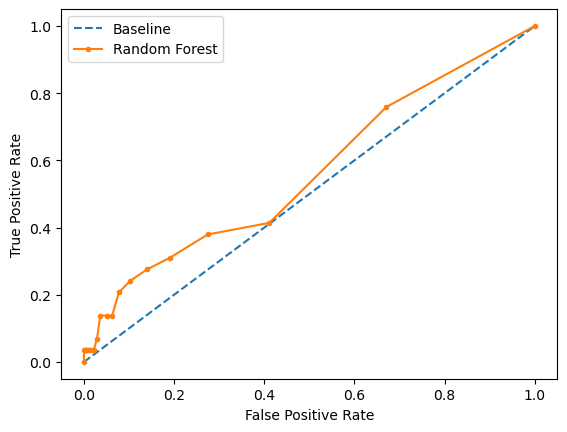

In [47]:
baseline = [0 for _ in range(len(y_test))]
baseline_auc = roc_auc_score(y_test, baseline)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()